# SARII

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
import fastai.basics as fai
import fastai.text as ftxt
import pandas as pd
import numpy as np

In [ ]:
import PIL
import textwrap
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw

In [ ]:
!pip install autocorrect

In [ ]:
import urllib.request
from wasabi import msg
from autocorrect import Speller

In [ ]:
import random
import os
import glob
import matplotlib.pyplot as plt

In [ ]:
import spacy
from collections import Counter
from string import punctuation
from spacy import displacy

## Data

In [125]:
df = pd.read_csv('allquotes.csv',header=None, names=['quote', 'author'])
df = df.drop(['author'], axis=1)
df = df.dropna()

In [126]:
df.head()

,quote
0,“Do one thing every day that scares you.”
1,"“We are what we pretend to be, so we must be c..."
2,"“When we love, we always strive to become bett..."
3,“Sometimes you wake up. Sometimes the fall kil...
4,"“Hold fast to dreams,For if dreams dieLife is ..."


In [127]:
df['quote'] = df['quote'].str.lower()

In [128]:
df.head()

,quote
0,“do one thing every day that scares you.”
1,"“we are what we pretend to be, so we must be c..."
2,"“when we love, we always strive to become bett..."
3,“sometimes you wake up. sometimes the fall kil...
4,"“hold fast to dreams,for if dreams dielife is ..."


In [129]:
valid_pct = 0.1 #validation percent
df = df.iloc[np.random.permutation(len(df))]
cut = int(valid_pct * len(df)) + 1
train_df, valid_df = df[cut:], df[:cut]

In [130]:
len(train_df), len(valid_df)

(10883, 1210)

In [ ]:
data_lm = ftxt.TextLMDataBunch.from_df('data', train_df, valid_df, text_cols='quote')

## Langueaje Model

In [ ]:
learn_lm = ftxt.language_model_learner(data_lm, ftxt.AWD_LSTM, pretrained=True)

In [ ]:
learn_lm.lr_find(); learn_lm.recorder.plot(skip_end=15)

In [ ]:
learn_lm.fit_one_cycle(20, 1e-2, moms=(0.8,0.7))

In [ ]:
learn_lm.save("lm-20")

In [ ]:
learn_lm.save_encoder('lm-20-encoder')

In [ ]:
learn_lm.unfreeze()

In [ ]:
learn_lm.lr_find(); learn_lm.recorder.plot(skip_end=15)

In [ ]:
learn_lm.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

## Validate and Save

In [ ]:
learn_lm.validate()

In [ ]:
learn_lm.save("lm-final")

In [ ]:
learn_lm.save_encoder('lm-encoder')

## Generating Quotes and Images

In [156]:
def generatequote():    
    quotes = []
    while quotes==[]:
        idea = learn_lm.predict("xxbos", n_words=24, temperature=0.75)
        ideas = idea.split("xxbos")
        if ideas[1][-1] == "”":
            quotes.append(ideas[1])
            
    message = quotes[0][:]
    message = '“'+message[3:].capitalize()
    message = message.replace(' . ','. ')
    message = message.replace(' ,',',')
    message = message.replace('’',"'")
    message = message.replace("do n't", "don't")
    message = message.replace("does n't", "doesn't")
    message = message.replace("ca n't", "can't")
    message = message.replace("we 're", "we're")
    message = message.replace(" 's", "'s")
    message = message.replace(" 've", "'ve")
    message = message.replace("you 're", "you're")
    spell = Speller()
    message = spell(message)
    msg.good("Message")
    return message[:-2]+'”'

In [157]:
def text2image(imageFile,font,quote):
    
    font = ImageFont.truetype(font, 75)

    para = textwrap.wrap(quote, width=42)

    MAX_W, MAX_H = 1080, 1080

    im = Image.open(imageFile).convert('RGBA')

    poly = Image.new('RGBA', (MAX_W,MAX_H))
    polydraw = ImageDraw.Draw(poly)

    polydraw.rectangle([(0,0),(MAX_W,MAX_H)], fill=(0,0,0,66), outline=None)
    
    im.paste(poly,mask=poly)

    draw = ImageDraw.Draw(im)

    current_h, pad = 370, 10

    for line in para:
        w, h = draw.textsize(line, font=font)
        draw.text(((MAX_W - w) / 2, current_h), line, font=font)
        current_h += h + pad
        
    current_h3, pad3 = 650, 10
    sitelink = "@SARII_bot"
    w, h = draw.textsize(sitelink, font=font)
    draw.text(((MAX_W - w) / 2, current_h3), sitelink, font=font)
    current_h3 += h + pad3

    plt.imshow(np.asarray(im))
    name = list(quote.split())[1:5]
    newfilename = "".join(name)+".png"
    finalpath = "generated/"+newfilename
    im.save(finalpath)
    msg.good("Image Saved")
    return(finalpath)

In [158]:
def downloadimage(key):
    imagepath = urllib.request.urlretrieve('https://source.unsplash.com/1080x1080/?'+str(key),"temp.jpg")[0]
    msg.good("Image Downloaded")
    return imagepath

In [159]:
def selectfont():
    fonts = []
    os.chdir("fonts")
    for file in glob.glob("*.ttf"):
        fonts.append("fonts/"+file)
    os.chdir("..")
    msg.good("Font selected")
    return random.choice(fonts)

# Extracting keys for image search

In [ ]:
!python -m spacy download en_core_web_md

In [ ]:
!python -m spacy validate

In [ ]:
import en_core_web_md

In [ ]:
nlp = en_core_web_md.load()

In [135]:
def get_key(text):
    result = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN'] # 1
    doc = nlp(text.lower()) # 2
    for token in doc:
        # 3
        if(token.text in nlp.Defaults.stop_words or token.text in punctuation):
            continue
        # 4
        if(token.pos_ in pos_tag):
            result.append(token.text)
    msg.good("Keys Extracted")
    return list(set(result)) # 5

In [147]:
message = generatequote()
print(message)
key = get_key(message)[0]
print(key)

✔ Message
“A life is about accepting the challenges along the way, choosing to keep moving forward, and savoring the journey.”
✔ Keys Extracted
life


# Result

In [164]:
def generate(): 
    print('')
    message = generatequote()
    try:
        keys = get_key(message)[:3]
        key = 'landscapes'
    except:
        msg.fail("Unable to retrieve key")
    imagepath = downloadimage(key)
    selectedfont = selectfont() 
    restultimage = text2image(imagepath,selectedfont,message)
    print('')
    msg.good("Done!")
    print('')
    msg.info("Image key: "+key)
    msg.info("Selected font: "+selectedfont)
    msg.info("Image path: "+restultimage)
    print('')
    print(message+' - #SARII #AI '+''.join(['#'+str(i.capitalize())+' ' for i in keys]))
    print('')

In [161]:
!rm -R generated && mkdir generated


✔ Message
✔ Keys Extracted
✔ Image Downloaded
✔ Font selected
✔ Image Saved

✔ Done!

ℹ Image key: landscapes
ℹ Selected font: fonts/Little Miracles Demo.ttf
ℹ Image path: generated/lifeisaboutaccepting.png

“A life is about accepting the challenges along the way, choosing to keep moving forward, and savoring the journey.” - #SARII #AI #Life #Journey #Way 



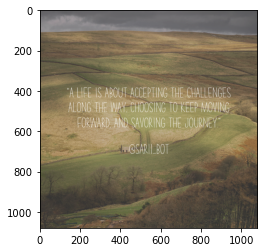

In [163]:
generate()